In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train','test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)

In [3]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\kwanm\\tensorflow_datasets\\mnist\\3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

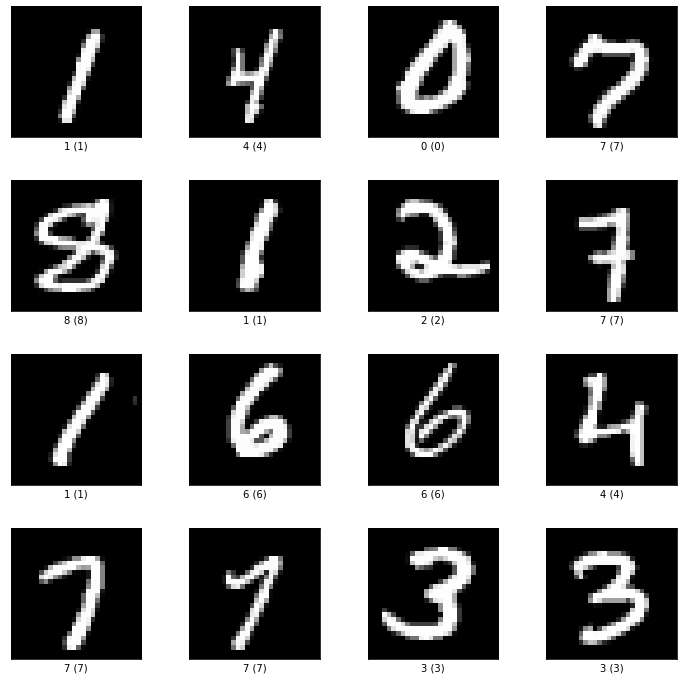

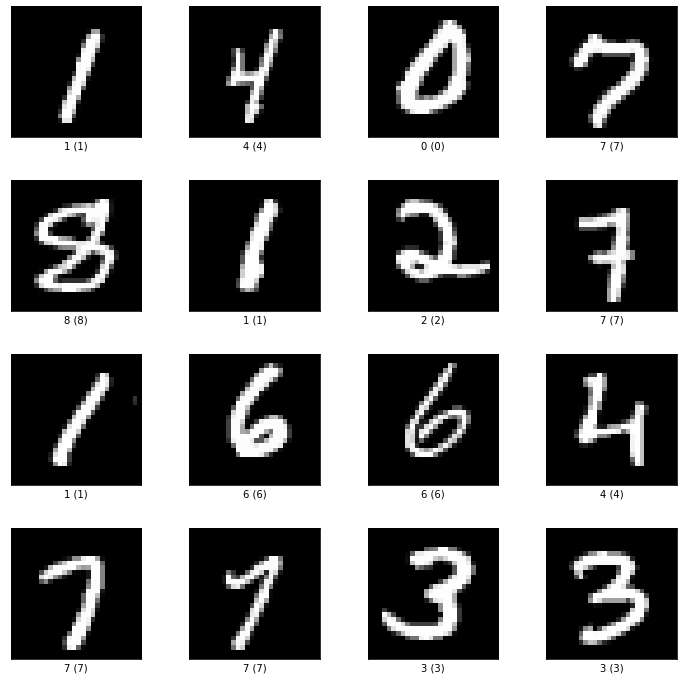

In [4]:
tfds.show_examples(ds_train, ds_info, rows=4, cols=4)

In [5]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32)/255.0, label

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(AUTOTUNE)

In [7]:
model = keras.Sequential([
    keras.Input((28,28,1)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(10, activation='softmax')
])

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
             optimizer=keras.optimizers.Adam(lr=0.001),
             metrics=['accuracy'])

model.fit(ds_train, epochs=5)
model.evaluate(ds_test)

Epoch 1/5
938/938 [==============================] - 6s 5ms/step - loss: 0.3743 - accuracy: 0.8964
Epoch 2/5
938/938 [==============================] - 4s 5ms/step - loss: 0.0692 - accuracy: 0.9801
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0504 - accuracy: 0.9851
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0354 - accuracy: 0.9895
Epoch 5/5
79/79 [==============================] - 0s 4ms/step - loss: 0.0607 - accuracy: 0.9812


[0.06071227416396141, 0.9811999797821045]

In [8]:
(ds2_train, ds2_test), ds2_info = tfds.load(
    'imdb_reviews',
    split=['train','test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)

ds2_info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='C:\\Users\\kwanm\\tensorflow_datasets\\imdb_reviews\\plain_text\\1.0.0',
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('text', 'label'),
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <SplitInfo num_examples=2500

In [9]:
for text,label in ds2_train:
    print(text, label)
    import sys
    sys.exit()

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int64)


SystemExit: 

C:\Users\kwanm\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [13]:
#TOKENIZATION
tokenizer = tfds.deprecated.text.Tokenizer()

def build_vocabulary():
    vocab = set()
    for text,_ in ds2_train:
        vocab.update(tokenizer.tokenize(text.numpy().lower()))
    return vocab

vocabulary = build_vocabulary()

encoder = tfds.deprecated.text.TokenTextEncoder(
    vocabulary, oov_token='<UNK>', lowercase=True, tokenizer=tokenizer)
                #oov = out of vocabulary

def my_encoding(text_tensor, label):
    return encoder.encode(text_tensor.numpy()), label

def encode_map(text, label):
    encoded_text, label = tf.py_function(
        my_encoding, inp=[text, label], Tout=(tf.int64, tf.int64))
    
    encoded_text.set_shape([None])
    label.set_shape([])
    
    return encoded_text, label

ds2_train = ds2_train.map(encode_map, num_parallel_calls=AUTOTUNE).cache()
ds2_train = ds2_train.shuffle(10000)
ds2_train = ds2_train.padded_batch(32, padded_shapes=([None],()))
ds2_train = ds2_train.prefetch(AUTOTUNE)

ds2_test = ds2_test.map(encode_map)
ds2_test = ds2_test.padded_batch(32, padded_shapes=([None],()))

model2 = keras.Sequential([
    layers.Masking(mask_value=0),
    layers.Embedding(input_dim=len(vocabulary)+2, output_dim=32),
    #BATCH_SIZE x 1000 -> BATCH_SIZE x 1000 x 32
    layers.GlobalAveragePooling1D(),
    #BATCH_SIZE x 32
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') #<0 -ve, >=0 +ve
])

model2.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(3e-4, clipnorm=1),
    metrics=['accuracy'])

model2.fit(ds2_train, epochs=10)
model2.evaluate(ds2_test)

Epoch 1/10
782/782 [==============================] - 23s 22ms/step - loss: 0.6883 - accuracy: 0.5589
Epoch 2/10
782/782 [==============================] - 16s 20ms/step - loss: 0.5642 - accuracy: 0.7968
Epoch 3/10
782/782 [==============================] - 16s 20ms/step - loss: 0.3839 - accuracy: 0.8699
Epoch 4/10
782/782 [==============================] - 15s 19ms/step - loss: 0.2913 - accuracy: 0.9006
Epoch 5/10
782/782 [==============================] - 15s 19ms/step - loss: 0.2433 - accuracy: 0.9156
Epoch 6/10
782/782 [==============================] - 15s 19ms/step - loss: 0.2114 - accuracy: 0.9274
Epoch 7/10
782/782 [==============================] - 15s 19ms/step - loss: 0.1811 - accuracy: 0.94050s - loss: 0.1811 - 
Epoch 8/10
782/782 [==============================] - 15s 19ms/step - loss: 0.1665 - accuracy: 0.9463
Epoch 9/10
782/782 [==============================] - 15s 19ms/step - loss: 0.1472 - accuracy: 0.9529
Epoch 10/10
782/782 [==============================] - 11s 14m

[0.28957200050354004, 0.8907600045204163]